# CSC412/2506  Assignment 3: Variational Auto Encoders

In this assignment we will learn how to preform efficient inference and learning in directed graphical models with continuous latent variables.We will use stochastic variational inference with automatic differentiation (SADVI) to approximate intractible posterior distributions. 
We will implement the two gradient estimators discussed in lecture, Score Function and Reparamterization, and experimentally demonstrate their properties such as biasedness and variance. 
We will use the reparameterization gradient estimators to optimize the ELBO of our latent variable model.

You can use automatic differentiation in your code.
You may also use a machine learning framework to specify the encoder and decoder neural networks, and provide gradientent optimizers such as ADAM.
However, you may not use any probabilistic modelling elements for these frameworks.
In particular, sampling from and evaluating densities under distributions must be written by you.

# Implementing the VAE [20pts]

In this assignment we will implement and investigate the Variational Auto Encoder on Binarized MNIST digits detailed in [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf) by Kingma and Welling (2013). Before starting, read this paper. In particular, we will implement model as described in Appendix C.

## Load and Prepare Data

Load the MNIST dataset, binarize the images, split into a training dataset of 10000 images and a test set of 10000 images. Also partition the training set into minibatches of size M=100.

In [25]:
import matplotlib

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import gzip
import struct
import array
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.misc.optimizers import adam
from autograd.scipy.special import logsumexp
from autograd.scipy.special import expit as sigmoid
import pickle

import matplotlib.pyplot as plt
import matplotlib.image
import matplotlib.cm as cm
from urllib.request import urlretrieve


D = 784

### Downloading and loading code for the MNIST dataset
### Code provided by instructors
def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)

def mnist():
    base_url = 'http://yann.lecun.com/exdb/mnist/'

    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(base_url + filename, filename)

    train_images = parse_images('data/train-images-idx3-ubyte.gz')
    train_labels = parse_labels('data/train-labels-idx1-ubyte.gz')
    test_images  = parse_images('data/t10k-images-idx3-ubyte.gz')
    test_labels  = parse_labels('data/t10k-labels-idx1-ubyte.gz')

    return train_images, train_labels, test_images, test_labels


def load_mnist():
    partial_flatten = lambda x : np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))
    one_hot = lambda x, k: np.array(x[:,None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels = mnist()
    train_images = partial_flatten(train_images) / 255.0
    test_images  = partial_flatten(test_images)  / 255.0
    train_labels = one_hot(train_labels, 10)
    test_labels = one_hot(test_labels, 10)
    N_data = train_images.shape[0]

    return N_data, train_images, train_labels, test_images, test_labels


In [27]:
# Loading the dataset
N_data, train_images, train_labels, test_images, test_labels = load_mnist()
train_images = torch.from_numpy(np.round(train_images[0:10000])).float()
train_labels = train_labels[0:10000]
test_images = torch.from_numpy(np.round(test_images[0:10000])).float()

batch_size = 100
num_batches = int(np.ceil(len(train_images) / batch_size))
# This function will be used to get batches instead of partitioning the dataset
def batch_indices(iter):
    idx = iter % num_batches
    return slice(idx * batch_size, (idx+1) * batch_size)

## Distributions [5pts]

Implement code to sample from and evaluate the log-pdf of diagonal multivariate gaussians $\mathcal{N}(x|\mu, \sigma^2 I)$ and Bernoulli distributions. For sampling from these distributions, you have access to samples from uniform and unit Gaussians, (`rand` and `randn`). Make sure you test you've implemented these correctly by comparing to standard packages!

In [28]:
# sampler from Diagonal Gaussian x~N(μ,σ^2 I)
def gauss(num_samples, mu, sigma, dim):
  return mu + sigma*torch.randn(num_samples, dim)


# sampler from Bernoulli
def ber(mu):
  return torch.where(torch.rand(*mu.shape) < mu, torch.tensor(1), torch.tensor(0))


# log-pdf of x under Diagonal Gaussian N(x|μ,σ^2 I)
def log_gauss(x, mu, sigma2, dim=None):
  ''' x: N x D
      mu: N x D
      sigma: N x D
  '''
  if dim is None:
    dim = mu.size(-1)
  return -0.5*(torch.sum((1./sigma2)*(x-mu)*(x-mu), -1) + dim*np.log(2*np.pi) + torch.sum(torch.log(sigma2), -1))


# log-pdf of x under Bernoulli
def log_ber(x, mu):
  ''' x: N x D
      mu: N x D
  '''
  return torch.sum(x * torch.log(mu) + (1 - x) * torch.log(1 - mu), -1)

## Defining Model Architecture [5pts]

Implement the model as defined in Appendix C. The MLPs will have a single hidden layer with Dh=500 hidden units. The dimensionality of the latent space will be Dz=2 for visualization purposes later.

Note that the output of the encoder will be $[\mu,\log\sigma^2]$. Why not ouput $\sigma^2$ directly? Keep this in mind when you sample from the distribution using your Diagonal Gaussian sampler.

In [29]:

# Set latent dimensionality=2 and number of hidden units=500.
Dz = 2
Dh = 500
# Define MLP for recognition model / "encoder"
# Provides parameters for q(z|x)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.lin1 = nn.Linear(D,Dh)
        self.mu = nn.Linear(Dh,Dz)
        self.sig = nn.Linear(Dh,Dz)

    def forward(self, x):
        out = torch.tanh(self.lin1(x))
        mu = self.mu(out)
        sigma = self.sig(out)
        return mu, sigma

# Define sample from recognition model
# Samples z ~ q(z|x)

def sample(mu, sigma):
  ''' Samples using output of encoder
      mu: B x Dz
      sigma: B x Dz
  '''
  if mu.dim() == 1:
    return gauss(1, mu, torch.exp(sigma/2), Dz).reshape(Dz)
  return gauss(mu.size(0), mu, torch.exp(sigma/2), Dz)

# Define MLP for generative model / "decoder"
# Provides parameters for distribution p(x|z)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.lin1 = nn.Linear(Dz,Dh)
        self.lin2 = nn.Linear(Dh,D)

    def forward(self, x):
        out = torch.tanh(self.lin1(x))
        theta = torch.sigmoid(self.lin2(out))
        return theta

## Variational Objective [7pts]

Here we will use the log-pdfs, the encoder, gaussian sampler, and decoder to define the Monte Carlo estimator for the mean of the ELBO over the minibatch.

In [30]:
# log_q(z|x) logprobability of z under approximate posterior N(μ,σ^2)
def logq_z_x(z, mu, sigma):
  return log_gauss(z, mu, torch.exp(sigma), Dz)
# log_p_z(z) log probability of z under prior
def logp_z(z):
  return log_gauss(z, torch.zeros_like(z), torch.ones_like(z), Dz)
# log_p(x|z) - conditional probability of data given latents.
def logp_x_z(x, theta):
  return log_ber(x, theta)
  
# Monte Carlo Estimator of mean ELBO with Reparameterization over M minibatch samples.
# This is the average ELBO over the minibatch

def ELBO(e, d, x):
  mu, sigma = e(x)
  z = sample(mu, sigma)
  theta = d(z)
  return torch.mean(logp_x_z(x, theta) + logp_z(z) - logq_z_x(z, mu, sigma))

## Optimize with Gradient Descent

Minimize the -ELBO with ADAM optimizer. You may use the optimizer provided by your framework

In [31]:
# Load Saved Model Parameters
try:
  encoder = torch.load('enc.pkl')
  decoder = torch.load('dec.pkl')
except FileNotFoundError:
  encoder = Encoder()
  decoder = Decoder()


In [32]:
# Set up ADAM optimizer
torch.manual_seed(7)
def batched_loss(e, d, iter):
    data_idx = batch_indices(iter)
    return -ELBO(e, d, train_images[data_idx, :])


# Train for ~200 epochs 
e_params = list(encoder.parameters())  
d_params = list(decoder.parameters())  

optimizer = optim.Adam(e_params+d_params, 0.001)

for iteration in range(20000):
  optimizer.zero_grad()
  loss = batched_loss(encoder, decoder, iteration)
  if iteration % 100 == 0:
    print('Epoch: ', iteration//100, ', ELBO: ', -loss.item())
  loss.backward() 
  optimizer.step()



Epoch:  0 ELBO:  -166.0288848876953
Epoch:  1 ELBO:  -165.06182861328125
Epoch:  2 ELBO:  -164.14085388183594
Epoch:  3 ELBO:  -162.55690002441406
Epoch:  4 ELBO:  -161.04287719726562
Epoch:  5 ELBO:  -160.3152618408203
Epoch:  6 ELBO:  -159.2111358642578
Epoch:  7 ELBO:  -157.85105895996094
Epoch:  8 ELBO:  -156.86647033691406
Epoch:  9 ELBO:  -155.98751831054688
Epoch:  10 ELBO:  -155.5888671875
Epoch:  11 ELBO:  -154.20802307128906
Epoch:  12 ELBO:  -153.71478271484375
Epoch:  13 ELBO:  -152.7686004638672
Epoch:  14 ELBO:  -152.226318359375
Epoch:  15 ELBO:  -152.70457458496094
Epoch:  16 ELBO:  -151.26002502441406
Epoch:  17 ELBO:  -152.24432373046875
Epoch:  18 ELBO:  -153.7427978515625
Epoch:  19 ELBO:  -150.72348022460938
Epoch:  20 ELBO:  -150.68934631347656
Epoch:  21 ELBO:  -148.8263702392578
Epoch:  22 ELBO:  -148.27166748046875
Epoch:  23 ELBO:  -147.65975952148438
Epoch:  24 ELBO:  -147.08670043945312
Epoch:  25 ELBO:  -146.70428466796875
Epoch:  26 ELBO:  -146.78590393066

In [33]:
# Save Optimized Model Parameters
torch.save(encoder, 'enc.pkl')
torch.save(decoder, 'dec.pkl')

## Report ELBO on Training and Test Set [3pts]

In [34]:
# ELBO on training set
print("Training set average ELBO: ", ELBO(encoder, decoder, train_images).item())
# ELBO on test set
print("Test set average ELBO: ", ELBO(encoder, decoder, test_images).item())

Training set average ELBO:  -137.45664978027344
Test set average ELBO:  -156.30831909179688


# Numerically Computing Intractable Integrals [10pts]

## Numerical Integration over Latent Space [5pts]

Since we chose a low dimensional latent space, we are able to perform [numerical integration](https://en.wikipedia.org/wiki/Riemann_sum) to evaluate integrals which are intractible in higher dimension. 

For instance, we will use this to integrate over the latent space. e.g. the $$p(z|x) = \frac{p(x|z)*p(z)}{p(x)}= \frac{p(x|z)*p(z)}{\int p(x|z)*p(z) dz}$$

We want to numerically compute that integral. However, since we are parameterizing $\log p(x|z)$ and $\log p(z)$ we will have
$$\log p(z|x) = \log p(x|z) + \log p(z) - \log \int \exp [\log p(x|z)+ \log p(z)] dz$$

You will write code which computes $\log \int \exp \log f(z) dz$ given an equally spaced  grid of $\log f(z)$s as input.
Note that if we approximate that integral with a numerical sum, in order for it to be numerically stable we will need `logsumexp`.

In [35]:
def logsumexp(exp, dim=None):
  a = torch.max(exp)
  if dim is None:
    return a + torch.log(torch.sum(torch.exp(exp-a)))
  return a + torch.log(torch.sum(torch.exp(exp-a), dim))
# Stable numerical integration over a 2d grid 
# of equally spaced (delta_z) evaluations logf(x)
def num_int(grid, dx):
  ''' grid: N x D x D
      dx: float
  '''
  return logsumexp(grid, -1) + np.log(dx*dx)

## Compare Numerical Log-Likelihood to ELBO [5pts]

We can use the numerical integration to compute the log-likeihood of a element in our dataset under our model. We can then compare the numerical integration to the estimate given by the ELBO.

In [36]:
torch.manual_seed(17)
# Define the delta_z to be the spacing of the grid
dz = 0.1
# Define a grid of delta_z spaced points [-4,4]x[-4,4]
def grid(min, max, delta):
  d = int((max - min)/delta + 1 + 1e-6)
  x = torch.arange(min,max+delta,delta).expand((d,d))
  y = torch.transpose(x, 0, 1)
  return torch.stack((x,y),-1).reshape(d*d,2)

# Sample an x from the data to evaluate the likelhiood
x = train_images[torch.randint(10000,(1,))]
# Compute log_p(x|z)+log_p(z) for every point on the grid
g=grid(-4,4,dz)
theta = decoder(g)
logg= logp_x_z(x, theta) + logp_z(g)
# Using your numerical integration code
# integrate log_p(x|z)+log_p(z) over z to find log_p(x)
logpx = num_int(logg, dz)
print(logpx)
# Check that your numerical integration is correct 
# by integrating log_p(x|z)+log_p(z) - log_p(x)
# If you've successfully normalized this should integrate to 0 = log 1
logg -= logpx
print(num_int(logg, dz))
# Now compute the ELBO on x
print(ELBO(encoder,decoder,x))
# Try this for multiple samples of x
# note that the ELBO is a lower bound to the true log_p(x)!
for i in range(10):
  x = train_images[torch.randint(10000,(1,))]
  logg= logp_x_z(x, theta) + logp_z(g)
  logpx = num_int(logg, dz)
  print(i)
  print('logpx: ', logpx.item())
  logg -= logpx
  print('normalized:', num_int(logg, dz).item())
  print('ELBO: ', ELBO(encoder,decoder,x).item())


tensor(-141.3425, grad_fn=<AddBackward0>)
tensor(-1.0014e-05, grad_fn=<AddBackward0>)
tensor(-146.3414, grad_fn=<MeanBackward0>)
0
logpx:  -119.6604232788086
normalized: 2.384185791015625e-06
ELBO:  -119.15409088134766
1
logpx:  -45.27827835083008
normalized: 1.9073486328125e-06
ELBO:  -46.434356689453125
2
logpx:  -171.21820068359375
normalized: -9.5367431640625e-07
ELBO:  -174.77072143554688
3
logpx:  -155.56243896484375
normalized: -6.67572021484375e-06
ELBO:  -174.27243041992188
4
logpx:  -148.9293212890625
normalized: -1.33514404296875e-05
ELBO:  -147.830322265625
5
logpx:  -106.296875
normalized: 3.337860107421875e-06
ELBO:  -109.70345306396484
6
logpx:  -96.29415130615234
normalized: -4.76837158203125e-07
ELBO:  -96.37335205078125
7
logpx:  -131.30157470703125
normalized: -7.152557373046875e-06
ELBO:  -133.14767456054688
8
logpx:  -92.84341430664062
normalized: 2.86102294921875e-06
ELBO:  -94.58243560791016
9
logpx:  -130.5458526611328
normalized: 3.814697265625e-06
ELBO:  -136.

# Data Space Visualizations [10pts]

In this section we will investigate our model by visualizing the distributions over data given by the generative model, samples from these distributions, and reconstructions of the data.

In [37]:
# Write a function to reshape 784 array into a 28x28 image for plotting
def plot(image):
  fig = plt.figure()
  fig.clf()
  ax = fig.add_subplot(111)
  cax = ax.matshow(image,cmap='gray_r')
  ax.patch.set_visible(False)
  plt.xticks(np.array([]))
  plt.yticks(np.array([]))
  plt.tight_layout()
  plt.grid(False)
  plt.show()
  

def get_im(x):
  s = x.size()
  return x.reshape((*s[:-1],28,28))


## Samples from the generative model [5pts]

Here you will sample from the generative model using ancestral sampling. 

* First sample a z from the prior. 
* Then use the generative model to parameterize a bernoulli distribution over x given z. Plot this distribution.
* Then sample x from the distribution. Plot this sample.

Do this for 10 samples z from the prior.

Concatenate all your plots into one 10x2 figure where the first column is the distribution over x and the second column is a sample from this distribution. Each  row will be a new sample from the prior.

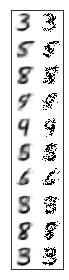

In [38]:
torch.manual_seed(27)
# Sample 10 z from prior
z = gauss(10, torch.zeros(Dz), torch.ones(Dz), Dz)

# For each z, plot p(x|z)
theta = decoder(z)
ptheta = get_im(theta)
# Sample x from p(x|z) 
x = ber(theta)
x = get_im(x)
# Concatenate plots into a figure
f = torch.cat((ptheta, x.float()), 2)
plot(f.detach().numpy().reshape(280,56))

## Reconstructions of data [5pts]

Here we will investigate the VAEs ability to reconstruct 10 inputs from the data. For each input ou will

* Plot the input $x$
* Use the recognition network to encode $x$ to the parameters for a distribution $q(z|x)$
* Sample $z \sim q(z|x)$
* Use the generative model to decode to the parameters for distribution $p(x|z)$. Plot this
* Sample $\tilde x \sim p(x|z)$. Plot this

Then you will concatenate all your plots into a 10x3 figure where the first column is the input data, the second column is the distribution over x, the third column is a reconstruction of the input. Each row will be a new sample from the data.

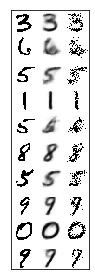

In [39]:
torch.manual_seed(37)
# Sample 10 xs from the data, plot.
s = torch.randint(10000, (10,))
x = test_images[s]
xim = get_im(x)
# For each x, encode to distribution q(z|x)
mu, sigma = encoder(x)
# For each x, sample distribution z ~ q(z|x)
z = sample(mu, sigma)
# For each z, decode to distribution p(x̃|z), plot.
theta = decoder(z)
thetaim = get_im(theta)
# For each x, sample from the distribution x̃ ~ p(x̃|z), plot.
samx = get_im(ber(theta)).float()
# Concatenate all plots into a figure.
f = torch.cat((xim, thetaim, samx), 2)
plot(f.detach().numpy().reshape(280,84))

# Latent Space Visualizations [15pts]

In this section we will investigate our model by visualizing the latent space through various methods. These will include encoding the data, decoding along a grid, and linearly interpolating between encdoded data.

## Latent embedding of data [5pts]

One way to understand what is represented in the latent space is to consider where it encodes elements of the data. Here we will produce a scatter plot in the latent space, where each point in the plot will be the mean vector for the distribution $q(z|x)$ given by the encoder. Further, we will colour each point in the plot by the class label for the input data. 

Hopefully our latent space will have learned to distinguish between elements from different classes, even though we never provided class labels to the model!

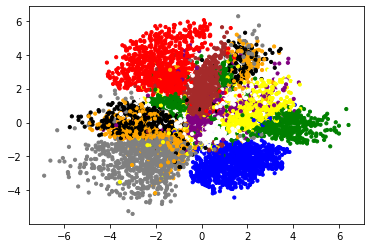

In [40]:
torch.manual_seed(47)
# Encode the training data
mu, sigma = encoder(train_images)
# Take the mean vector of each encoding
mu = mu.detach().numpy()
# Plot these mean vectors in the latent space with a scatter
# Colour each point depending on the class label
cmap = ['red', 'blue', 'green', 'yellow', 'black', 'purple', 'brown', 'gray', 'white', 'orange']

color = np.zeros(10000)
for i in range(10):
  color = np.where(train_labels[:,i] == 1, cmap[i], color)
plt.scatter(mu[:,0], mu[:,1], s=10, c=color)

## Decoding along a lattice [5pts]

We can also understand the "learned manifold" by plotting the generative distribution $p(x|z)$ for each point along a grid in the latent space. We will replicate figure 4b in the paper.

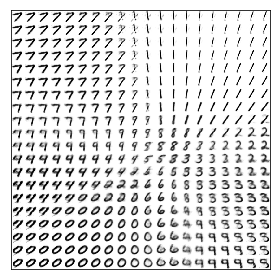

In [41]:
# Create a 20x20 equally spaced grid of z's
# (use the  previous figure to help you decide appropriate bounds for the grid)
g = grid(-6, 4.45, 0.55)
# For each z on the grid plot the generative distribution over x
theta = decoder(g)
# concatenate these plots to a lattice of distributions
p = get_im(theta).reshape(20,20,28,28)
f = p.transpose(2,1).reshape(560,560)


plot(f.detach().numpy())

## Interpolate between two classes [5pts]

A common technique to assess latent representations is to interpolate between two points.

Here we will encode 3 pairs of data points with different classes. Then we will linearly interpolate between the mean vectors of their encodings. We will plot the generative distributions along the linear interpolation.

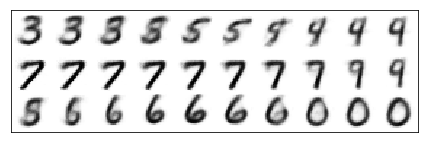

In [42]:
torch.manual_seed(57)
# Function which gives linear interpolation z_α between za and zb
def interpolate(za, zb, steps=10):
  x = torch.linspace(za[0].item(), zb[0].item(), steps)
  y = torch.linspace(za[1].item(), zb[1].item(), steps)
  return torch.stack((x,y), -1)
# Sample 3 pairs of data with different classes
def sample_diff():
  i1 = torch.randint(10000,(1,))
  i2 = torch.randint(10000,(1,))
  x1 = train_images[i1]
  x2 = train_images[i2]
  while all(test_labels[i2] == test_labels[i1]):
    i2 = torch.randint(10000,(1,))
    x2 = train_images[i2]
  return torch.stack((x1.squeeze(),x2.squeeze()))

pair1 = sample_diff()
pair2 = sample_diff()
pair3 = sample_diff()
# Encode the data in each pair, and take the mean vectors
mu1, sigma1 = encoder(pair1)
mu2, sigma2 = encoder(pair2)
mu3, sigma3 = encoder(pair3)
# Linearly interpolate between these mean vectors
z1 = interpolate(mu1[0], mu1[1])
z2 = interpolate(mu2[0], mu2[1])
z3 = interpolate(mu3[0], mu3[1])
# Along the interpolation, plot the distributions p(x|z_α)
theta1 = get_im(decoder(z1))
theta2 = get_im(decoder(z2))
theta3 = get_im(decoder(z3))
# Concatenate these plots into one figure
p = torch.cat((theta1, theta2, theta3), 1).transpose(0,1).reshape(3*28,10*28)
plot(p.detach().numpy())

# Posteriors and Stochastic Variational Inference [20pts]

Here we will use numerical integration to plot the "true" posterior $p(z|x)$ which is generally intractable. We will compare the intractable true posterior to the variational approximate posterior given by the recognition model $q(z|x)$.

Then we will use the generative model to perform inference other inference tasks. In particular, we will see that the purpose of the encoder was only to make training the generative model tractable, and that we can do inference using the generative model completely without the encoder. To illustrate this we will perform the inference task of producing a generative distribution over the bottom half of the digit conditioned on the top half. We will achieve this with stochastic variational inference.

## Plotting Posteriors [5pts]

Here we will plot the true posterior by evaluating $\log p(x|z)+\log p(z)$ on an equally spaced grid over z then numerically integrating over this grid to find the log-normalizer $\log p(x)$. This will give us the intractable true posterior $p(z|x)$.

Then we will compare the true posterior to the approximate posterior given by the recognition model $q(z|x)$. Does the recognition model produce a good approximate posterior to the intractable true posterior?

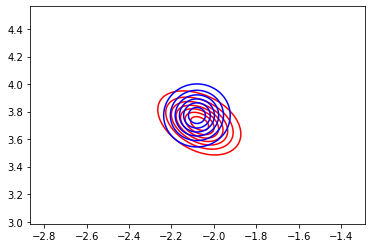

In [43]:
torch.manual_seed(68)
# Sample an element x from the dataset to plot posteriors for
x = train_images[torch.randint(10000,(1,))]
# x = train_images[5]
# Define a grid of equally spaced points in z
# The grid needs to be fine enough that the plot is nice
# To keep the integration tractable 
# I reccomend centering your grid at the mean of q(z|x)
mu, sigma = encoder(x.squeeze())
s = mu + 4*torch.sum(torch.exp(sigma/2))
e = mu - 4*torch.sum(torch.exp(sigma/2))
m,_ = torch.sort(torch.stack((s,e)), 0)
delta = 0.01

xg = torch.arange(m[0][0].item(),m[1][0].item()+delta,delta)
yg = torch.arange(m[0][1].item(),m[1][1].item()+delta,delta)
xd = xg.size(0)
yd = yg.size(0)
xgg = xg.expand((yd,xd)).transpose(0,1)
ygg = yg.expand((xd,yd))
g = torch.stack((xgg,ygg),-1).reshape(xd*yd,2)
# Evaluate log_p(x|z) + log_p(z) for every z on the grid
theta = decoder(g)
logg= logp_x_z(x, theta) + logp_z(g)
# Numerically integrate log_p(x|z) + log_p(z) to get log_p(x)
logpx = num_int(logg, delta)
# Produce a grid of normalized log_p(z|x)
pz_x = torch.exp(logg - logpx).view((xd,yd))
# Plot the contours of p(z|x) (note, not log)
detx = xg.detach().numpy()
dety = yg.detach().numpy()
plt.contour(detx, dety,pz_x.transpose(0,1).detach().numpy(),colors='red')
# Evaluate log_q(z|x) recognition network for every z on grid
logq = logq_z_x(g, mu, sigma).reshape(xd,yd)
# Plot the contours of q(z|x) on previous plot
qz_x = torch.exp(logq)
plt.contour(detx, dety,qz_x.transpose(0,1).detach().numpy(),colors='blue')
plt.show()

## True posterior for top of digit [5pts]

In this question we will plot the "true" posterior given only the top of the image, $p(z|x_{top})$. 

Realize that the generative model gives a Bernoulli distribution over each pixel in the image. We can easily evaluate the likelihood of only the top of an image by evaluating under only those corresponding dimensions of the generative model.

In [44]:
torch.manual_seed(22)
# Function which returns only the top half of a 28x28 array
# This will be useful for plotting, as well as selecting correct bernoulli params
def top(imgs):
  return imgs[:,0:28*14]
# log_p(x_top | z) (hint: select top half of 28x28 bernoulli param array)
def logpxtop(x, theta):
  return log_ber(top(x), top(theta))
# Sample an element from the data set and take only its top half: x_top
x = train_images[torch.randint(10000,(1,))]
xtop = top(x)
# Define a grid of equally spaced points in z
mu, sigma = encoder(x.squeeze())
s = mu + 4*torch.sum(torch.exp(sigma/2))
e = mu - 4*torch.sum(torch.exp(sigma/2))
m,_ = torch.sort(torch.stack((s,e)), 0)
delta = 0.01

xg = torch.arange(m[0][0].item(),m[1][0].item()+delta,delta)
yg = torch.arange(m[0][1].item(),m[1][1].item()+delta,delta)
xd = xg.size(0)
yd = yg.size(0)
xgg = xg.expand((yd,xd)).transpose(0,1)
ygg = yg.expand((xd,yd))
g = torch.stack((xgg,ygg),-1).reshape(xd*yd,2)
# Evaluate log_p(x_top | z) + log_p(z) for every z on grid
theta = decoder(g)
logg= logpxtop(x, theta) + logp_z(g)
# Numerically integrate to get log_p(x_top)
logpx_top = num_int(logg, delta)
# Normalize to produce grid of log_p(z|x_top)
pz_xtop = torch.exp(logg - logpx_top).view((xd,yd))
# Plot the contours of p(z|x_top)
detx = xg.detach().numpy()
dety = yg.detach().numpy()


## Learn approximate posterior for top of digit with Stochastic Variational Inference [10 pts]

In this question we will see how we can use SVI to learn an approximate posterior to $p(z|x_{top})$ which we just obtained through intractable integration.

Note that we can't just use our recognition model, because our encoder doesn't know what to do with only top halfs of images. Instead, we will initialize a variational distribution $q(z) = \mathcal{N}(z| \mu,\sigma^2 I)$ and optimize the ELBO to minimize the KL divergence between it and the true distribution.

In [45]:
torch.manual_seed(87)
# Initialize parameters μ and logσ for variational distribution q(z)
params = [torch.zeros(2, requires_grad=True), torch.zeros(2, requires_grad=True)]
M = 100
# Define mean ELBO over M samples z ~ q(z)
# using log_p(z), log_p(x_top | z), and q(z|x_top)
def ELBOtop(params):
  mu = params[0]
  sigma = params[1]
  z =  gauss(M, mu, torch.exp(sigma/2), Dz)
  theta = decoder(z)
#   r = 
#   print(r.shape)
  return torch.mean(logp_z(z) + logpxtop(x,theta) - logq_z_x(z, mu, sigma))
# Loss for SVI is -1*ELBO
def batched_loss(params, iter):
    return -ELBOtop(params)
obj = grad(batched_loss)
# Set up ADAM to optimize μ and logσ^2

# Optimize for a few iterations until convergence (you can use a larger stepsize here)
optimizer = optim.Adam(params, 0.1)

for iteration in range(100):
  optimizer.zero_grad()
  loss = batched_loss(params, iteration)
  
  print(iteration, 'ELBO: ', -loss.item())
  loss.backward() 
  optimizer.step()

0 ELBO:  -171.56256103515625
1 ELBO:  -173.61611938476562
2 ELBO:  -167.52230834960938
3 ELBO:  -164.2451629638672
4 ELBO:  -165.52259826660156
5 ELBO:  -164.3226776123047
6 ELBO:  -149.7920379638672
7 ELBO:  -151.64971923828125
8 ELBO:  -148.0950164794922
9 ELBO:  -143.77569580078125
10 ELBO:  -131.2336883544922
11 ELBO:  -118.41417694091797
12 ELBO:  -122.5434341430664
13 ELBO:  -122.76933288574219
14 ELBO:  -110.3427734375
15 ELBO:  -112.73036193847656
16 ELBO:  -109.36257934570312
17 ELBO:  -98.31846618652344
18 ELBO:  -99.51195526123047
19 ELBO:  -97.5621566772461
20 ELBO:  -87.85298919677734
21 ELBO:  -92.10948181152344
22 ELBO:  -81.45724487304688
23 ELBO:  -79.0534896850586
24 ELBO:  -85.20912170410156
25 ELBO:  -77.9336929321289
26 ELBO:  -77.94123077392578
27 ELBO:  -72.97732543945312
28 ELBO:  -77.60872650146484
29 ELBO:  -73.06326293945312
30 ELBO:  -73.0345230102539
31 ELBO:  -72.61001586914062
32 ELBO:  -73.21766662597656
33 ELBO:  -71.1795654296875
34 ELBO:  -68.10191345

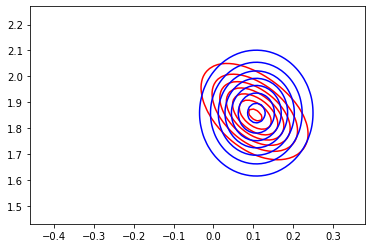

In [46]:
# On previous plot of contours of p(z|x_top) plot the optimized q(z)
logq = log_gauss(g, params[0], torch.exp(params[1]))
q = torch.exp(logq).view((xd,yd))
plt.contour(detx, dety,pz_xtop.transpose(0,1).detach().numpy(),colors='red')
plt.contour(detx, dety, q.transpose(0,1).detach().numpy(), colors='blue')
plt.show()

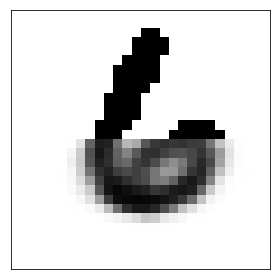

In [47]:
torch.manual_seed(97)
# Sample z ~ q(z)
z = gauss(1, params[0], torch.exp(params[1]/2), Dz)
# Use generative model p(x|z) to produce distribution over x
theta = decoder(z)
# Extract the bottom half of this generative distribution: p(x_bot| z)
xbot = theta[:,14*28:]
# Concatenate the x_top and p(x_bot | z) and plot.
plot(torch.cat((xtop,xbot)).reshape(28,28).detach().numpy())